In [698]:
from dotenv import load_dotenv
load_dotenv()

True

In [699]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b",)

In [700]:
# llm.invoke("what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?")

In [701]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [702]:
from langchain_experimental.utilities import PythonREPL
repl=PythonREPL()

In [703]:
repl.run("x=10\ny=x+10\nprint(y)")

'20\n'

In [704]:
from typing import Annotated,Literal
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage,AIMessage

In [705]:
@tool
def python_repl_tool(code: Annotated[str, "Python code to execute"]):
    """Executes Python code using REPL and returns stdout."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Execution failed. Error: {repr(e)}"
    return f"Executed:\n```python\n{code}\n```\nOutput: {result}"

In [706]:
python_repl_tool.invoke("x=10\ny=x+10\nprint(y)")

'Executed:\n```python\nx=10\ny=x+10\nprint(y)\n```\nOutput: 20\n'


WE HAVE TWO SUB AGENT

1.RESEARCHER- internet

2.CODER- executing the code

There is no routing logic

it is simply going to return the next candidate(next_agent)

this next is containig the next candidate name

In [707]:
class Router(TypedDict):
    next:Literal['researcher','coder','FINISH']

In [708]:
from langgraph.graph import MessagesState,StateGraph,START, END

In [709]:
class State(MessagesState):
    next:str
    done: bool = False

In [710]:
members=["researcher","coder"]

In [711]:

options = members+["FINISH"]

In [712]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [713]:
llm_with_structure_output = llm.with_structured_output(Router)

## Now let's make 3 agents

In [714]:
from langgraph.types import Command

In [715]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my response {'next': 'researcher'}
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
    
    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}
    
    return Command(goto=goto, update={"next":goto})

In [716]:

from langgraph.prebuilt import create_react_agent

from langchain_core.messages import AIMessage, HumanMessage

In [717]:
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="""
You are a researcher. Tasks:
- Use web search
- Give reliable info with sources
- No calculations
- Be concise and accurate
""")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )
    

In [718]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="""
You are a Python expert.
- Use only Python REPL tool
- Include print() for output
- Handle errors gracefully
""")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
    


this is my orchestration flow with langgraph

In [719]:
graph=StateGraph(State)

In [720]:
graph.add_node("supervisor",supervisor_agent)
graph.add_node("researcher",research_agent)
graph.add_node("coder",coder_agent)

In [721]:
graph.add_edge(START,"supervisor")

In [722]:
app=graph.compile()

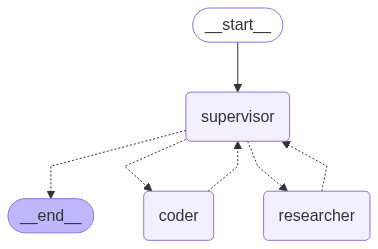

In [723]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [725]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************
(('coder:da2bcca6-4bd7-be41-fb81-9a18836e90d9',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking for the square root of 42. Let me think about how to approach this. I know that in Python, I can use the math module's sqrt function to calculate square roots. So first, I need to import math. Then, compute math.sqrt(42). But wait, maybe I should check if 42 is a non-negative number since square roots of negative numbers are complex. But 42 is positive, so it's fine. Let me write a simple Python code snippet to calculate this. Also, the user might want the answer printed out, so I should include a print statement. Let me put it all together: import math and print the square root of 42. That should give the user the result they need. Let me make sure there are no typos. Yes, that looks right. The co

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


**********BELOW IS MY GOTO***************
FINISH
((), {'supervisor': {'next': '__end__'}})
**********BELOW IS MY STATE***************


In [727]:
for s in app.stream({"messages": [("user", "what is an efficent python approach  to get prime number?")]}, subgraphs=True):
    print(s)


**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
(('researcher:076d5494-3a71-0ab4-a7a4-4d0a67bfc669',), {'agent': {'messages': [AIMessage(content='To efficiently generate prime numbers in Python, consider the following approaches:\n\n### 1. **Sieve of Eratosthenes** (for generating all primes ≤ n)\nThis algorithm marks non-prime numbers in a list and is highly efficient for range-based prime generation. Time complexity: **O(n log log n)**.\n\n```python\ndef sieve(n):\n    primes = [True] * (n+1)\n    primes[0:2] = [False, False]\n    for i in range(2, int(n**0.5)+1):\n        if primes[i]:\n            primes[i*i : n+1 : i] = [False] * len(primes[i*i : n+1 : i])\n    return [i for i, is_prime in enumerate(primes) if is_prime]\n```\n\n**Source**: [Eratosthenes Sieve - GeeksforGeeks](https://www.geeksforgeeks.org/sieve-of-eratosthenes/)\n\n---\n\n### 2. **Optimized Trial Division** (for checking if a number is prime)\nThis method checks di

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


**********BELOW IS MY GOTO***************
FINISH
((), {'supervisor': {'next': '__end__'}})


In [729]:
for s in app.stream({"messages": [("user", "Building Autonomous AI Agents with LangGraph, Groq & LangChain: Researcher + Coder Duo")]}, subgraphs=True):
    print(s)


**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
(('researcher:942666b8-1590-27f5-27ff-60369a72fff0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about building autonomous AI agents using LangGraph, Groq, and LangChain, specifically a Researcher + Coder duo. Let me start by understanding each component.\n\nFirst, LangGraph is a framework for building stateful, workflow-based applications with LangChain. It allows for creating nodes and edges to define workflows. Then, Groq is a company that provides high-performance AI inference using their own hardware, which can be useful for speeding up model responses. LangChain itself is a framework for developing applications with language models, providing tools for prompts, memory, and integrations.\n\nThe Researcher + Coder duo concept is likely about splitting the agent\'s role into two specialized parts: one that does resear

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


**********BELOW IS MY GOTO***************
FINISH
((), {'supervisor': {'next': '__end__'}})
